<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/11_HistoryMatching_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install jcopml "jcopdl<2.0"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/01_df_merged.csv', index_col="case_num")
df['oil_prod_cum'] = df['oil_prod_cum'] * 1e-5
df.head()

days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
case_num                                                                
0            0  0.000000            0.0       0.00000            0.00   
0           31  0.084932        26614.0       8.25035         1740.71   
0           62  0.169863        21427.7      14.89290         1740.71   
0           93  0.254795        18809.7      20.72390         1740.71   
0          124  0.339726        16676.6      25.89370         1740.71   

          water_inj_cum category      Kh_Kv     inj_rate  permeability  \
case_num                                                                 
0                   0.0    train  16.423475  1740.711355    288.983333   
0               53962.1    train  16.423475  1740.711355    288.983333   
0              107924.0    train  16.423475  1740.711355    288.983333   
0              161886.0    train  16.423475  1740.711355    288.983333   
0              215848.0    train  16.423475  1740.711355    288.983333   

          porosity    prod_bhp  thickness  
case_num                                   
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632

In [25]:
df.drop(columns=["oil_prod_rate", 'water_inj_rate', 'water_inj_cum', 'category'], inplace = True)

In [26]:
df1 = df.copy()
df1.head()

days     years  oil_prod_cum      Kh_Kv     inj_rate  permeability  \
case_num                                                                       
0            0  0.000000       0.00000  16.423475  1740.711355    288.983333   
0           31  0.084932       8.25035  16.423475  1740.711355    288.983333   
0           62  0.169863      14.89290  16.423475  1740.711355    288.983333   
0           93  0.254795      20.72390  16.423475  1740.711355    288.983333   
0          124  0.339726      25.89370  16.423475  1740.711355    288.983333   

          porosity    prod_bhp  thickness  
case_num                                   
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632  
0         0.163009  796.992254  23.718632

In [27]:
df1.drop(columns = 'years', inplace = True)
df1.head()

days  oil_prod_cum      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                                       
0            0       0.00000  16.423475  1740.711355    288.983333  0.163009   
0           31       8.25035  16.423475  1740.711355    288.983333  0.163009   
0           62      14.89290  16.423475  1740.711355    288.983333  0.163009   
0           93      20.72390  16.423475  1740.711355    288.983333  0.163009   
0          124      25.89370  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [69]:
ts_train, ts_test = train_test_split(df1, test_size=0.3, shuffle = False)
ts_train.shape, ts_test.shape

((84700, 8), (36300, 8))

In [37]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import TensorDataset, DataLoader

In [38]:
seq_len = 60
bs = 16

train_set = TimeSeriesDataset(ts_train, 'oil_prod_cum', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'oil_prod_cum', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (1411, 60, 8)
Note: last 39 data excluded

(N, S, F): (604, 60, 8)
Note: last 59 data excluded



In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc (x)
        return x, hidden

In [40]:
config = set_config({
    'input_size': train_set.n_feature,
    'seq_len': train_set.n_seq,
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0,
    'output_size': 1,
})

In [43]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config)

In [44]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 43840.9255 | Test_cost  = 44541.0169 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 41518.6964 | Test_cost  = 42486.0096 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 39570.9112 | Test_cost  = 40573.4968 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 37744.5248 | Test_cost  = 38769.6762 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 36019.2334 | Test_cost  = 37062.0215 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 34385.6897 | Test_cost  = 35443.3217 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 32837.8818 | Test_cost  = 33908.4180 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 31371.2148 | Test_cost  = 32453.1312 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 29981.8332 | Test_cost  = 31073.8633 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 28666.3342 | Test_cost  = 29767.3644 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 27421.6196 | Test_cost  = 28530.6570 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 26244.8066 | Test_cost  = 27360.9387 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 25133.1815 | Test_cost  = 26255.5698 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 24084.1686 | Test_cost  = 25212.0301 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 23095.3005 | Test_cost  = 24227.8939 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 22164.2019 | Test_cost  = 23300.8249 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 21288.5928 | Test_cost  = 22428.6165 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 20466.2397 | Test_cost  = 21608.8046 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 19686.8050 | Test_cost  = 20827.0975 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 18901.6953 | Test_cost  = 19913.1704 | 


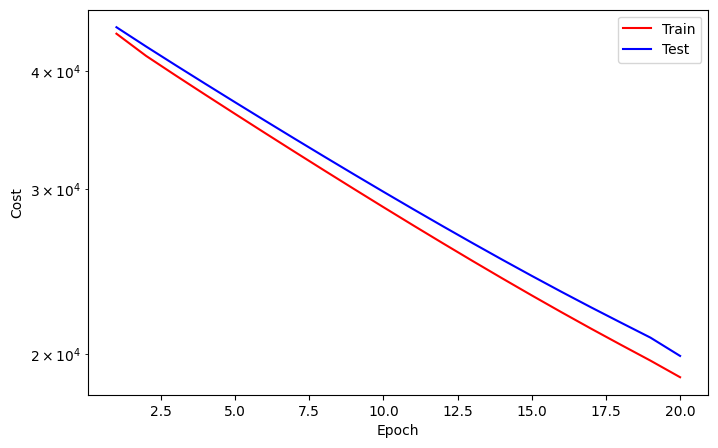

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 17946.1393 | Test_cost  = 18990.1153 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 17122.9433 | Test_cost  = 18288.3007 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 16378.6864 | Test_cost  = 17517.0458 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 15691.7116 | Test_cost  = 16903.3720 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 15033.0207 | Test_cost  = 16197.8075 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 14390.7146 | Test_cost  = 15515.3327 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 13794.3845 | Test_cost  = 14930.9907 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 13243.1640 | Test_cost  = 14498.2629 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 12708.1130 | Test_cost  = 13832.6266 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 12185.9908 | Test_cost  = 13334.9771 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 11693.0318 | Test_cost  = 12815.4794 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 11211.8616 | Test_cost  = 12385.0285 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 10777.9196 | Test_cost  = 11896.7688 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 10312.6453 | Test_cost  = 11440.2232 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 9906.3650 | Test_cost  = 11018.1409 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 9505.9891 | Test_cost  = 10629.6849 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 9150.8616 | Test_cost  = 10251.1936 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 8789.6908 | Test_cost  = 9892.8980 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 8459.5406 | Test_cost  = 9545.3355 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 8114.8559 | Test_cost  = 9213.1774 | 


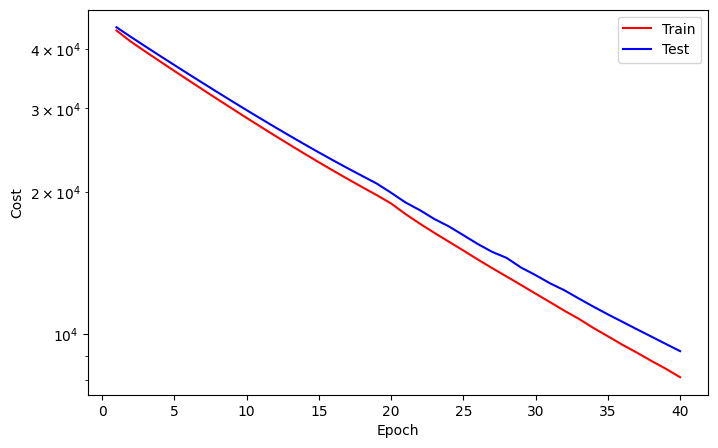

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 7795.6946 | Test_cost  = 8880.9676 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 7493.6695 | Test_cost  = 8569.4530 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 7225.2562 | Test_cost  = 8276.0829 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 6971.8737 | Test_cost  = 8003.9954 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 6699.9535 | Test_cost  = 7721.1783 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 6434.3956 | Test_cost  = 7456.0645 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 6181.2860 | Test_cost  = 7212.0820 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 5955.4582 | Test_cost  = 6953.7783 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 5737.7594 | Test_cost  = 6770.9474 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 5531.6221 | Test_cost  = 6508.5521 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 5356.2434 | Test_cost  = 6390.7604 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 5156.8336 | Test_cost  = 6137.6695 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 4979.5469 | Test_cost  = 5933.1510 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 4808.4677 | Test_cost  = 5766.2865 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 4652.8119 | Test_cost  = 5563.7480 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 4487.3007 | Test_cost  = 5370.0761 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 4301.0546 | Test_cost  = 5188.7852 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 4141.6524 | Test_cost  = 5032.3395 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 4012.6809 | Test_cost  = 4878.5480 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 3872.8154 | Test_cost  = 4740.9222 | 


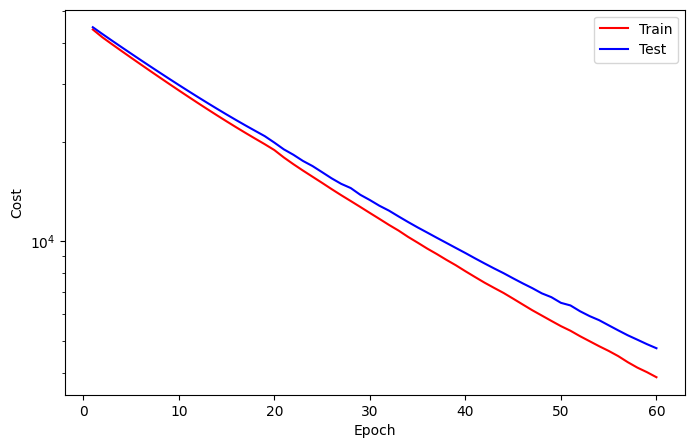

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 3755.1530 | Test_cost  = 4577.5469 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 3595.6097 | Test_cost  = 4425.0661 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 3466.0988 | Test_cost  = 4345.6912 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 3376.3506 | Test_cost  = 4201.0623 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 3243.5591 | Test_cost  = 4215.0376 | 
==> EarlyStop patience =  1 | Best test_cost: 4201.0623


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 3187.6199 | Test_cost  = 3944.8744 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 3054.8755 | Test_cost  = 3830.6757 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 2949.6333 | Test_cost  = 3711.7684 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 2851.7876 | Test_cost  = 3599.0812 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 2741.9329 | Test_cost  = 3473.9896 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 2654.1054 | Test_cost  = 3370.9066 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 2569.5932 | Test_cost  = 3278.8237 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 2489.3353 | Test_cost  = 3190.3193 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 2406.1183 | Test_cost  = 3097.7659 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 2324.1361 | Test_cost  = 3006.5659 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 2258.7370 | Test_cost  = 2910.5524 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 2191.1032 | Test_cost  = 2819.8445 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 2139.9176 | Test_cost  = 2753.0497 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 2052.8172 | Test_cost  = 2676.9073 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 2015.7278 | Test_cost  = 2637.3117 | 


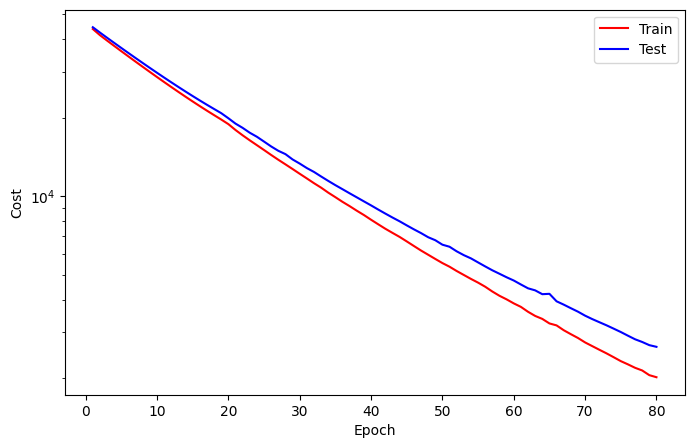

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 1956.0393 | Test_cost  = 2531.9872 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 1903.6831 | Test_cost  = 2477.1830 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 1867.8078 | Test_cost  = 2416.4782 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 1793.4275 | Test_cost  = 2342.4979 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 1801.2932 | Test_cost  = 2292.7435 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 1728.7397 | Test_cost  = 2234.1916 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 1654.4974 | Test_cost  = 2169.9764 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 1609.3898 | Test_cost  = 2113.3658 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 1553.0534 | Test_cost  = 2048.4719 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 1569.4674 | Test_cost  = 2022.8027 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 1503.6103 | Test_cost  = 1983.2753 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 1462.3441 | Test_cost  = 1898.8145 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 1403.1462 | Test_cost  = 1856.4406 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 1365.3577 | Test_cost  = 1806.4682 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 1343.7871 | Test_cost  = 1761.7716 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 1309.4597 | Test_cost  = 1719.6329 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 1269.7141 | Test_cost  = 1682.8905 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 1249.3504 | Test_cost  = 1666.4586 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 1219.5426 | Test_cost  = 1618.1968 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 1192.6089 | Test_cost  = 1591.0162 | 


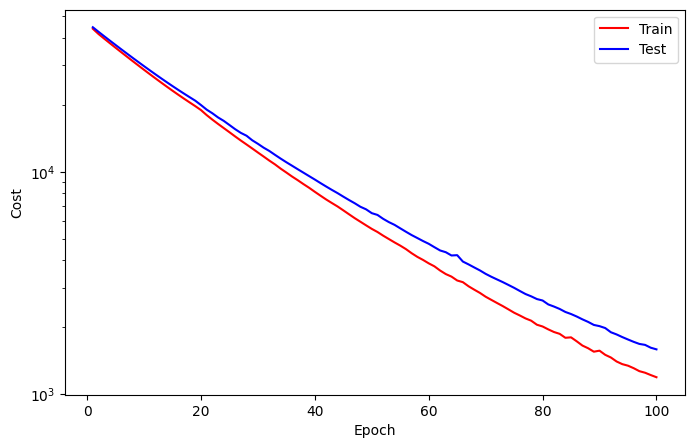

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 1159.1440 | Test_cost  = 1537.8434 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 1158.9091 | Test_cost  = 1538.1194 | 
==> EarlyStop patience =  1 | Best test_cost: 1537.8434


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 1168.0600 | Test_cost  = 1553.7126 | 
==> EarlyStop patience =  2 | Best test_cost: 1537.8434


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 1154.1991 | Test_cost  = 1491.8006 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 1133.0263 | Test_cost  = 1457.3294 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 1096.3719 | Test_cost  = 1413.3548 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 1067.4935 | Test_cost  = 1390.8415 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 1031.5254 | Test_cost  = 1341.6089 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 1009.6337 | Test_cost  = 1333.3147 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 1000.4203 | Test_cost  = 1314.7666 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 989.1044 | Test_cost  = 1289.5995 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 973.4414 | Test_cost  = 1267.1084 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 960.8620 | Test_cost  = 1228.2604 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 927.7838 | Test_cost  = 1210.4050 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 909.7724 | Test_cost  = 1177.5189 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 899.1977 | Test_cost  = 1162.1098 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 877.5330 | Test_cost  = 1146.3572 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 868.9012 | Test_cost  = 1132.1680 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 1040.5346 | Test_cost  = 1484.4438 | 
==> EarlyStop patience =  1 | Best test_cost: 1132.1680


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 1081.6398 | Test_cost  = 1263.9448 | 


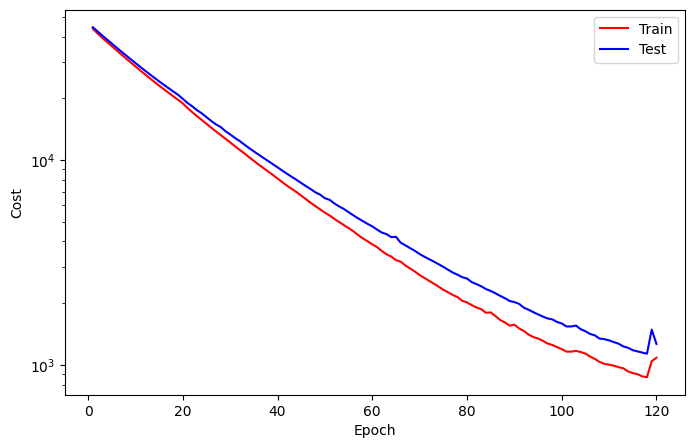

==> EarlyStop patience =  2 | Best test_cost: 1132.1680


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 983.8805 | Test_cost  = 1155.2542 | 
==> EarlyStop patience =  3 | Best test_cost: 1132.1680


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 894.2115 | Test_cost  = 1104.3750 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 858.7409 | Test_cost  = 1128.7592 | 
==> EarlyStop patience =  1 | Best test_cost: 1104.3750


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 867.7721 | Test_cost  = 1114.9245 | 
==> EarlyStop patience =  2 | Best test_cost: 1104.3750


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 834.6076 | Test_cost  = 1058.1379 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 822.5890 | Test_cost  = 1027.0831 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 807.5380 | Test_cost  = 1007.6267 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 801.1293 | Test_cost  = 1013.7679 | 
==> EarlyStop patience =  1 | Best test_cost: 1007.6267


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 843.8746 | Test_cost  = 1011.0342 | 
==> EarlyStop patience =  2 | Best test_cost: 1007.6267


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 798.5121 | Test_cost  = 999.9025 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 785.4265 | Test_cost  = 981.2470 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 791.6568 | Test_cost  = 954.0008 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 756.0844 | Test_cost  = 946.0343 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 765.9616 | Test_cost  = 950.6929 | 
==> EarlyStop patience =  1 | Best test_cost: 946.0343


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 751.5931 | Test_cost  = 942.6060 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 738.1773 | Test_cost  = 922.7022 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 729.0867 | Test_cost  = 922.9789 | 
==> EarlyStop patience =  1 | Best test_cost: 922.7022


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 751.3653 | Test_cost  = 888.0675 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 735.9962 | Test_cost  = 950.6651 | 
==> EarlyStop patience =  1 | Best test_cost: 888.0675


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 752.0937 | Test_cost  = 906.2641 | 


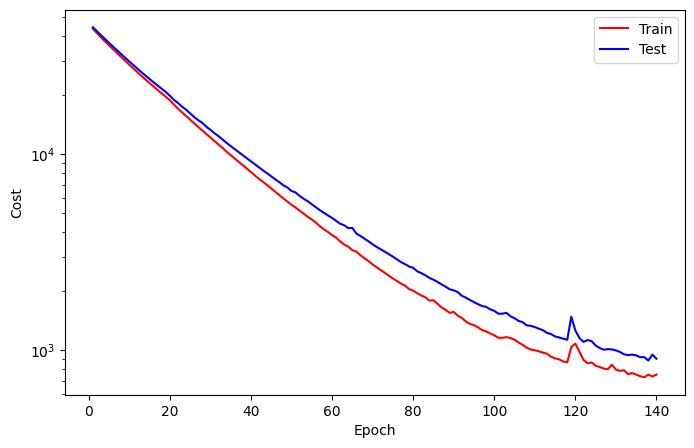

==> EarlyStop patience =  2 | Best test_cost: 888.0675


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 739.0254 | Test_cost  = 877.1193 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 729.6193 | Test_cost  = 911.4402 | 
==> EarlyStop patience =  1 | Best test_cost: 877.1193


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 733.6998 | Test_cost  = 869.2018 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 712.9210 | Test_cost  = 879.3155 | 
==> EarlyStop patience =  1 | Best test_cost: 869.2018


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 708.1192 | Test_cost  = 862.3289 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 705.3504 | Test_cost  = 850.2519 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 693.5472 | Test_cost  = 830.0981 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 755.7754 | Test_cost  = 895.2874 | 
==> EarlyStop patience =  1 | Best test_cost: 830.0981


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 797.3038 | Test_cost  = 944.0778 | 
==> EarlyStop patience =  2 | Best test_cost: 830.0981


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 786.9246 | Test_cost  = 873.2950 | 
==> EarlyStop patience =  3 | Best test_cost: 830.0981


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 754.4953 | Test_cost  = 892.6029 | 
==> EarlyStop patience =  4 | Best test_cost: 830.0981


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 752.7203 | Test_cost  = 849.4006 | 
==> EarlyStop patience =  5 | Best test_cost: 830.0981
==> Execute Early Stopping at epoch: 152 | Best test_cost: 830.0981
==> Best model is saved at model


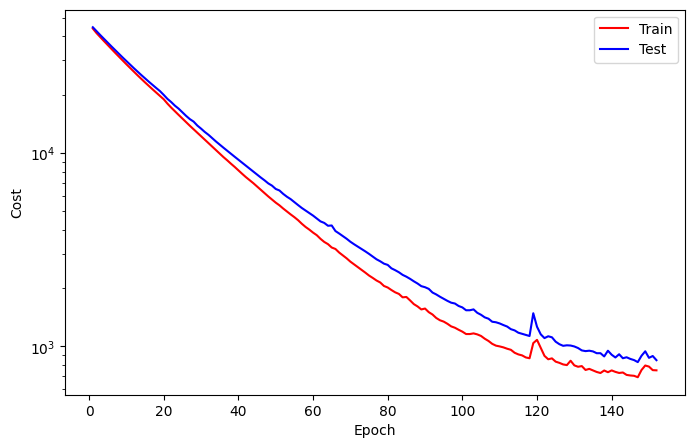

Execution Time: 466.5331144332886 Second


In [45]:
import time
# Mulai mengukur waktu
start_time = time.time()

while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Selesai mengukur waktu
end_time = time.time()

# Hitung lama waktu eksekusi
execution_time = end_time - start_time
print("Execution Time:", execution_time, "Second")

______________

Sanity Check

In [135]:
ts_train, ts_test = train_test_split(df1, test_size=0.3, shuffle = False)
ts_train.shape, ts_test.shape

((84700, 8), (36300, 8))

In [136]:
# Define train forecast set and create train forecast loader
train_forecast_set = TimeSeriesDataset(ts_train, 'oil_prod_cum', 1)
trainforecastloader = DataLoader(train_forecast_set)

# Define test forecast set and create test forecast loader
test_forecast_set = TimeSeriesDataset(ts_test, 'oil_prod_cum', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (84699, 1, 8)
Note: last 0 data excluded

(N, S, F): (36299, 1, 8)
Note: last 0 data excluded



In [137]:
# Remove the last row from ts_train
ts_train = ts_train.iloc[:-1]

# Remove the last row from ts_train
ts_test = ts_test.iloc[:-1]
ts_train.shape, ts_test.shape

((84699, 8), (36299, 8))

In [138]:
def data4pred(model, trainforecastloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in trainforecastloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()
    return np.array(preds), np.array(targets)

In [139]:
# Call the modified data4pred function to get preds and targets
train_preds, train_targets = data4pred(model, trainforecastloader, device)

# Add the predicted values and targets to the ts_train DataFrame
ts_train['targets'] = train_targets
ts_train['predicted_values'] = train_preds

In [140]:
ts_train = ts_train.reset_index(drop = False)

In [141]:
ts_train.head(130)

case_num  days  oil_prod_cum      Kh_Kv     inj_rate  permeability  \
0           0     0       0.00000  16.423475  1740.711355    288.983333   
1           0    31       8.25035  16.423475  1740.711355    288.983333   
2           0    62      14.89290  16.423475  1740.711355    288.983333   
3           0    93      20.72390  16.423475  1740.711355    288.983333   
4           0   124      25.89370  16.423475  1740.711355    288.983333   
..        ...   ...           ...        ...          ...           ...   
125         1   124      31.89340  96.690954  2216.996775    127.801703   
126         1   155      38.83340  96.690954  2216.996775    127.801703   
127         1   186      45.53370  96.690954  2216.996775    127.801703   
128         1   217      52.00750  96.690954  2216.996775    127.801703   
129         1   248      58.26480  96.690954  2216.996775    127.801703   

     porosity    prod_bhp  thickness    targets  predicted_values  
0    0.163009  796.992254  23.718632   8.250350         20.463093  
1    0.163009  796.992254  23.718632  14.892900         21.517349  
2    0.163009  796.992254  23.718632  20.723900         24.803841  
3    0.163009  796.992254  23.718632  25.893700         26.460238  
4    0.163009  796.992254  23.718632  30.485001         27.916489  
..        ...         ...        ...        ...               ...  
125  0.265198  672.408364  50.103320  38.833401         43.251530  
126  0.265198  672.408364  50.103320  45.533699         49.524837  
127  0.265198  672.408364  50.103320  52.007500         53.021637  
128  0.265198  672.408364  50.103320  58.264801         55.269085  
129  0.265198  672.408364  50.103320  64.314400         61.081745  

[130 rows x 11 columns]

In [145]:
def data4pred(model, testforecastloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in testforecastloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()
    return np.array(preds), np.array(targets)

In [146]:
# Call the modified data4pred function to get preds and targets
test_preds, test_targets = data4pred(model, testforecastloader, device)

# Add the predicted values and targets to the ts_train DataFrame
ts_test['targets'] = test_targets
ts_test['predicted_values'] = test_preds

In [147]:
ts_test = ts_test.reset_index(drop = False)

In [148]:
ts_test.head(120)

case_num  days  oil_prod_cum      Kh_Kv     inj_rate  permeability  \
0         700     0        0.0000  30.131087  1169.818916    275.721455   
1         700    31       26.6338  30.131087  1169.818916    275.721455   
2         700    62       47.1917  30.131087  1169.818916    275.721455   
3         700    93       64.5124  30.131087  1169.818916    275.721455   
4         700   124       79.2770  30.131087  1169.818916    275.721455   
..        ...   ...           ...        ...          ...           ...   
115       700  3565      200.9860  30.131087  1169.818916    275.721455   
116       700  3596      201.3550  30.131087  1169.818916    275.721455   
117       700  3627      201.7240  30.131087  1169.818916    275.721455   
118       700  3658      202.0930  30.131087  1169.818916    275.721455   
119       700  3689      202.4620  30.131087  1169.818916    275.721455   

     porosity    prod_bhp  thickness     targets  predicted_values  
0    0.125615  331.130088  72.276135   26.633801          5.032811  
1    0.125615  331.130088  72.276135   47.191700         37.272457  
2    0.125615  331.130088  72.276135   64.512398         53.139843  
3    0.125615  331.130088  72.276135   79.277000         67.754013  
4    0.125615  331.130088  72.276135   91.874496         85.618767  
..        ...         ...        ...         ...               ...  
115  0.125615  331.130088  72.276135  201.354996        169.706314  
116  0.125615  331.130088  72.276135  201.723999        167.790985  
117  0.125615  331.130088  72.276135  202.093002        166.188705  
118  0.125615  331.130088  72.276135  202.462006        164.763397  
119  0.125615  331.130088  72.276135  202.832001        163.336792  

[120 rows x 11 columns]

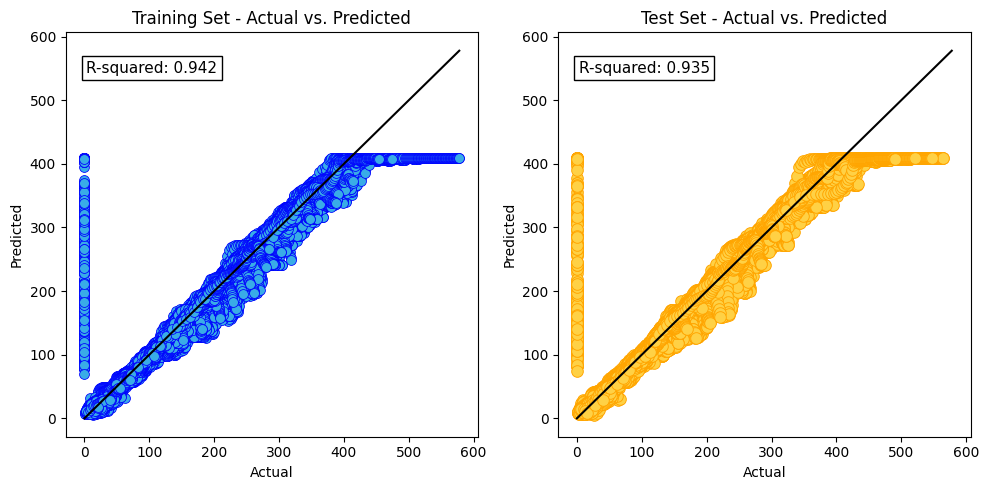

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R-squared scores
train_r2 = r2_score(ts_train["targets"], ts_train["predicted_values"])
test_r2 = r2_score(ts_test["targets"], ts_test["predicted_values"])

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': ts_train["targets"], 'Predicted': ts_train["predicted_values"]})
test_data = pd.DataFrame({'Actual': ts_test["targets"], 'Predicted': ts_test["predicted_values"]})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0], s=50, color='#39ACE7', edgecolor='blue')
axes[0].set_title('Training Set - Actual vs. Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(ts_train["targets"].max(), ts_test["predicted_values"].max())],
             [0, max(ts_train["targets"].max(), ts_test["predicted_values"].max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#ffd145', edgecolor='orange')
axes[1].set_title('Test Set - Actual vs. Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(ts_train["targets"].max(), ts_test["predicted_values"].max())],
             [0, max(ts_train["targets"].max(), ts_test["predicted_values"].max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/00_History_Matching/Pictures/ActualPredPlot - RNN.png', dpi = 600)
plt.show()

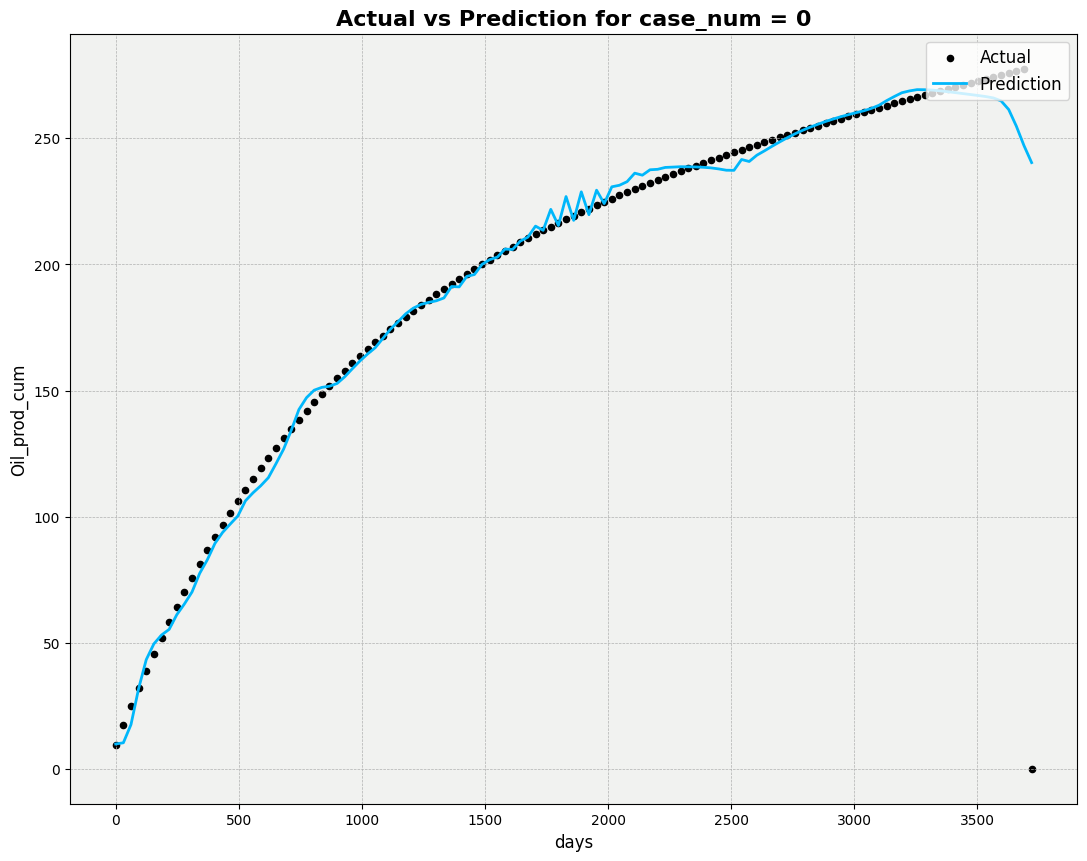

In [144]:
import matplotlib.pyplot as plt

plot_1 = ts_train[ts_train['case_num'] == 1]

# Create the line plot
fig, ax1 = plt.subplots(figsize=(13, 10))

# Plot scatter for "predicted_values" column
ax1.scatter(plot_1['days'], plot_1['targets'], color='black', s=20, label='Actual', marker='o')

# Plot line for "preds" column
ax1.plot(plot_1['days'], plot_1['predicted_values'], color='#00b7fb', linewidth=2, label='Prediction')

ax1.set_xlabel('days', fontsize=12)
ax1.set_ylabel('Oil_prod_cum', fontsize=12)

# Add gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Customize the title font size and style
plt.title('Actual vs Prediction for case_num = 0', fontsize=16, fontweight='bold')

# Customize the legend font size
plt.legend(loc='upper right', fontsize=12)

# Customize the tick label font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a background color
ax1.set_facecolor('#F1F2F0')
plt.savefig('/content/drive/MyDrive/00_History_Matching/Pictures/Case 1.png', dpi = 600)
plt.show()